In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from collections import Counter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import re
import tweepy
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TFTrainingArguments, BertForSequenceClassification, BertTokenizer 
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


In [2]:
# https://www.kaggle.com/datasets/sujaykapadnis/bitcoin-tweets

In [3]:
TRAIN_DIRECTORY = "big-files/tweets.csv"

In [4]:
# –£—Å—Ç–∞–Ω–æ–≤–∏—Ç–µ —Å–≤–æ–∏ –∫–ª—é—á–∏ API
API_KEY = ""
API_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
BEARER_TOKEN = ""

# 1. Data Exploration and Preprocessing

### 1.1 Loading the Dataset and Understanding its Structure

In [5]:
# # –ù–∞—Å—Ç—Ä–æ–π–∫–∞ Tweepy —Å –∫–ª—é—á–∞–º–∏ API
# client = tweepy.Client(
#     bearer_token=BEARER_TOKEN,
#     consumer_key=API_KEY,
#     consumer_secret=API_KEY_SECRET,
#     access_token=ACCESS_TOKEN,
#     access_token_secret=ACCESS_TOKEN_SECRET
# )

In [6]:
# def fetch_tweets(query, count):
#     tweets = tweepy.Paginator(client.search_recent_tweets, 
#                                        query=query,
#                                        tweet_fields=["created_at", "text"],
#                                        max_results=100
#                                        ).flatten(limit=count)
#     tweets_list = [[tweet.created_at, tweet.text] for tweet in tweets]
#     return pd.DataFrame(tweets_list, columns=["timestamp", "text"])

# # –°–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö
# df = fetch_tweets("#Bitcoin", 10)
# df.to_csv("big-files/crypto_tweets.csv", index=False)

In [7]:
# tweets = pd.read_csv("big-files/crypto_tweets.csv")
# tweets

In [8]:
# Load the data
df = pd.read_csv(TRAIN_DIRECTORY)
df

token                     date  reply_count  like_count  \
0      bitcoin  2022-01-01 00:00:00.000           20         207   
1      bitcoin  2022-01-01 00:00:00.000          232        3405   
2      bitcoin  2022-01-01 00:00:00.000            2         861   
3      bitcoin  2022-01-01 00:00:00.000           18         306   
4      bitcoin  2022-01-01 00:00:00.000           35         721   
...        ...                      ...          ...         ...   
76792  bitcoin  2023-06-22 00:00:00.000            8         204   
76793  bitcoin  2023-06-22 00:00:00.000            8         298   
76794  bitcoin  2023-06-22 00:00:00.000           17          86   
76795  bitcoin  2023-06-22 00:00:00.000          193        3048   
76796  bitcoin  2023-06-22 00:00:00.000           53       43524   

       retweet_count  quote_count  \
0                 31            3   
1                286           27   
2                 12            0   
3                 30            9   
4                 35            1   
...              ...          ...   
76792             35            2   
76793             17            4   
76794             17            0   
76795            771           42   
76796          46438            1   

                                                    text sentiment_label  \
0      Most people underestimate the impact #Bitcoin ...         Neutral   
1      #Bitcoin has started a new yearly candle https...         Neutral   
2      @DESTROYBINARY did people forget that the amog...         Neutral   
3      In 2017, miners attempted to assert control ov...        Negative   
4      Yearly Close \nMonthly Close\nDaily Close\n\nh...        Positive   
...                                                  ...             ...   
76792  IMF says while a few countries have banned #Bi...        Negative   
76793  Fear, Greed &amp; Bitcoin | #SheCrypto https:/...         Neutral   
76794  I know I may be unpopular for saying this but ...         Neutral   
76795  #Bitcoin now has the support of presidential c...        Positive   
76796  All unclaimed tokens will be burned by 4:00PM ...         Neutral   

       sentiment_score  
0             0.717482  
1             0.810814  
2             0.606978  
3             0.510956  
4             0.988296  
...                ...  
76792         0.615765  
76793         0.687251  
76794         0.532809  
76795         0.935171  
76796         0.758979  

[76797 rows x 9 columns]

In [9]:
# We see information about the dimension of our dataframe
df.shape 

(76797, 9)

In [10]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76797 entries, 0 to 76796
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            76797 non-null  object 
 1   date             76797 non-null  object 
 2   reply_count      76797 non-null  int64  
 3   like_count       76797 non-null  int64  
 4   retweet_count    76797 non-null  int64  
 5   quote_count      76797 non-null  int64  
 6   text             76797 non-null  object 
 7   sentiment_label  76797 non-null  object 
 8   sentiment_score  76797 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.3+ MB


In [11]:
# The number of unique values for each column
df.nunique() 

token                  1
date                 538
reply_count         1821
like_count          7323
retweet_count       2690
quote_count          584
text               75955
sentiment_label        3
sentiment_score    75530
dtype: int64

The data is well-structured and complete, with no missing values. This ensures that it‚Äôs ready for analysis without needing extensive preprocessing, allowing for accurate insights into user behavior and sentiment around Bitcoin.

### 1.2. Perform basic exploratory data analysis (EDA) to understand the distribution

In [12]:
# Check for missing values
df.isnull().sum()

token              0
date               0
reply_count        0
like_count         0
retweet_count      0
quote_count        0
text               0
sentiment_label    0
sentiment_score    0
dtype: int64

In [13]:
# Check for duplicates and non-dublicates
df.duplicated().value_counts()

False    76734
True        63
Name: count, dtype: int64

In [14]:
# Remove duplicates
df = df.drop_duplicates()

In [15]:
# Sentiment describe
df["sentiment_score"].describe()

count    76734.000000
mean         0.713478
std          0.141160
min          0.340653
25%          0.592395
50%          0.710428
75%          0.833892
max          0.993558
Name: sentiment_score, dtype: float64

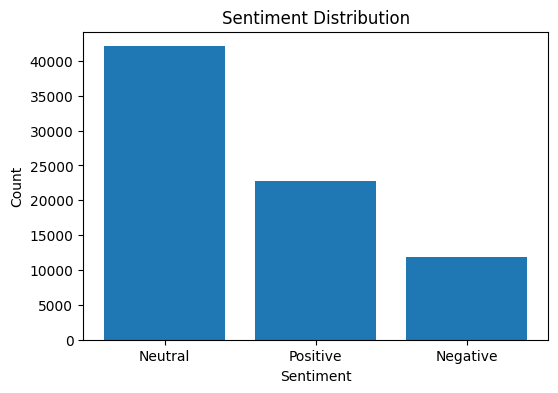

In [16]:
# Visualization of sentiments
sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [17]:
# Clean text function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags 
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Replace multiple whitespace characters with a single space
    text = text.lower()  # Convert text to lowercase
    return text


In [18]:
# Get cleaned text
df.loc[:, "clean_text"] = df["text"].apply(clean_text)

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\1719401625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "clean_text"] = df["text"].apply(clean_text)


In [19]:
# Join all in one for using
all_text = ' '.join(df["clean_text"])

In [20]:
# Adding custom stopwords (the, is, a...)
custom_stopwords = set(STOPWORDS)
# custom_stopwords.add('word')

# Creating the word cloud while excluding stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords, max_words=100).generate(all_text)

In [21]:
# Extract frequencies from the word cloud
word_frequencies = wordcloud.process_text(all_text) 
word_freq_counter = Counter(word_frequencies)   # sort and display word frequencies

for word, freq in word_freq_counter.most_common(20): # Display 20 words
    print(f"{word}: {freq}")

bitcoin: 17418
will: 5908
btc: 5120
now: 3729
amp: 3633
new: 3599
crypto: 3213
people: 3039
time: 2844
one: 2839
buy: 2692
money: 2308
today: 2203
world: 2203
year: 2152
price: 2045
day: 2009
u: 1866
see: 1838
going: 1833


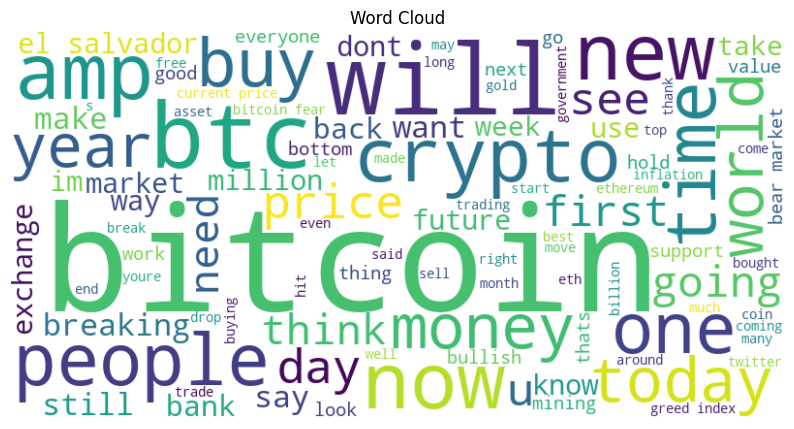

In [22]:
# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

Conclusion:
Terms like "bitcoin," "btc," and "crypto" highlight the central theme, while words such as "will," "now," and "new" suggest a focus on upcoming events and recent developments. The presence of terms like "buy," "price," and "money" indicates that the conversations frequently touch on financial matters and market dynamics.

In [23]:
# Converting a date to a normal format
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Lets make sure that the conversion was successful
df["date"].head(3)

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\2938940306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


0   2022-01-01
1   2022-01-01
2   2022-01-01
Name: date, dtype: datetime64[ns]

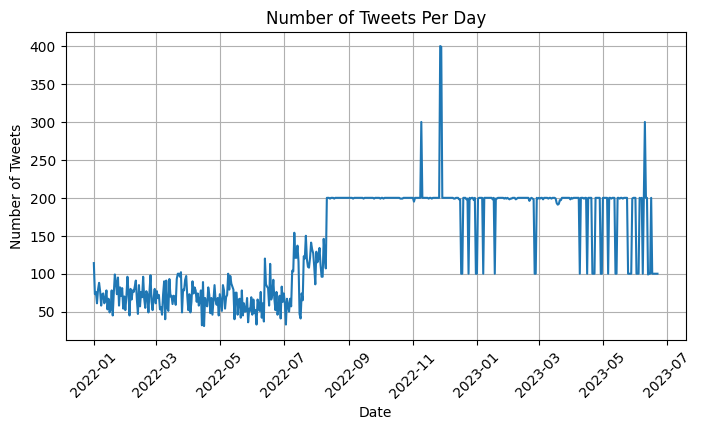

In [24]:
# Number of tweets per day
tweets_per_day = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(8, 4))
plt.plot(tweets_per_day.index, tweets_per_day.values)
plt.title("Number of Tweets Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

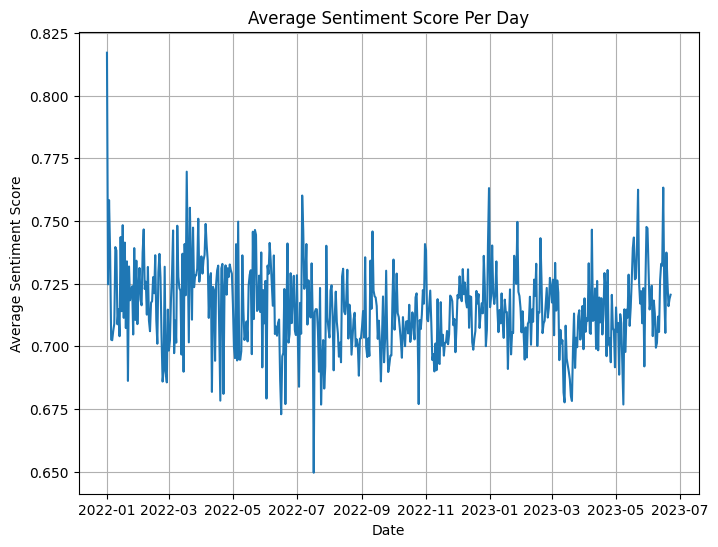

In [25]:
# Plot average sentiment score per day
average_sentiment_per_day = df.groupby(df['date'].dt.date)['sentiment_score'].mean()

plt.figure(figsize=(8, 6))
average_sentiment_per_day.plot()
plt.title('Average Sentiment Score Per Day')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

Conclusion: 
- The data on tweet counts shows that activity varies daily. 
- Periods with a high number of tweets do not always coincide with periods when the average sentiment was higher or lower. This suggests that tweet activity does not always directly affect the overall sentiment on social media. - A sharp increase or decrease in tweet counts may correspond with specific events that influence the overall sentiment.

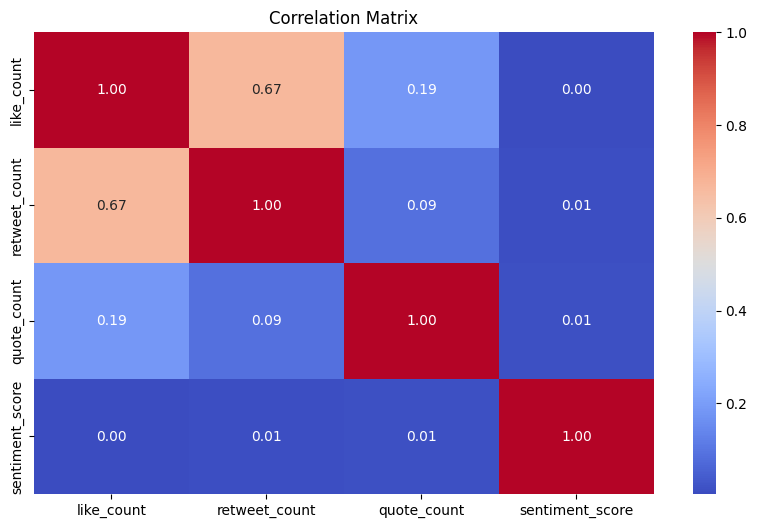

In [26]:
# Correlation matrix
correlation_matrix = df[["like_count", "retweet_count", "quote_count", "sentiment_score"]].corr()

# Building a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Conclusion:
- There is a moderate correlation between likes and retweets, indicating that tweets with more likes tend to also have more retweets. However, there is little to no relationship between these metrics and the tweet‚Äôs sentiment or the number of times the tweet is quoted.
- Retweets and quotes have a very weak relationship with each other.
- Sentiment is almost independent of likes, retweets, and quotes.

These results suggest that tweet engagement metrics (likes, retweets, and quotes) are generally not strongly related to each other or to the sentiment of the tweets.

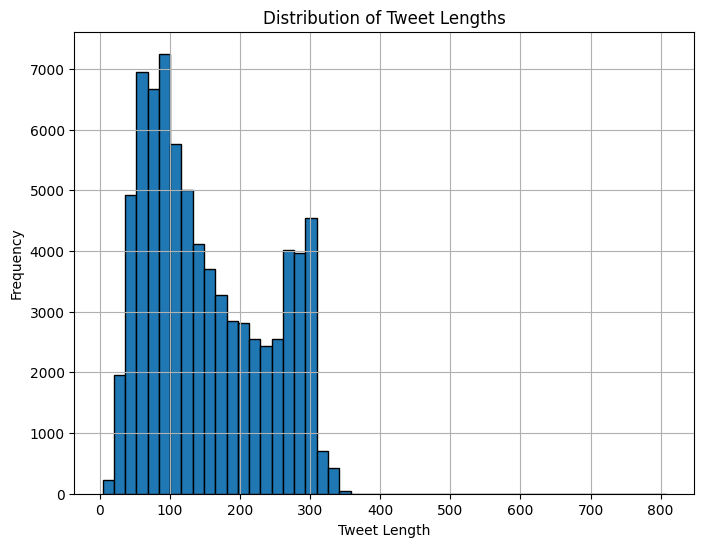

In [27]:
# Tweet length
plt.figure(figsize=(8, 6))
plt.hist(df['text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

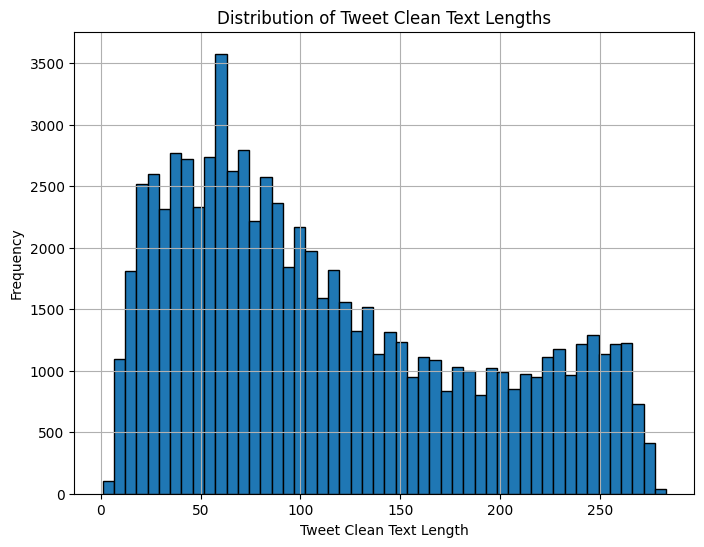

In [28]:
# Tweet length clean text
plt.figure(figsize=(8, 6))
plt.hist(df['clean_text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Clean Text Lengths")
plt.xlabel("Tweet Clean Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Conclusion:
- The cleaning process affected the length of tweets. The lengths of the cleaned tweets still vary widely, indicating that the cleaning did not significantly alter the distribution of tweet lengths.

# 2. Data Preprocessing and Tokenization

### 2.1 Tokenize the text data using a pre-trained tokenizer from a transformer model

In [29]:
df

token       date  reply_count  like_count  retweet_count  \
0      bitcoin 2022-01-01           20         207             31   
1      bitcoin 2022-01-01          232        3405            286   
2      bitcoin 2022-01-01            2         861             12   
3      bitcoin 2022-01-01           18         306             30   
4      bitcoin 2022-01-01           35         721             35   
...        ...        ...          ...         ...            ...   
76792  bitcoin 2023-06-22            8         204             35   
76793  bitcoin 2023-06-22            8         298             17   
76794  bitcoin 2023-06-22           17          86             17   
76795  bitcoin 2023-06-22          193        3048            771   
76796  bitcoin 2023-06-22           53       43524          46438   

       quote_count                                               text  \
0                3  Most people underestimate the impact #Bitcoin ...   
1               27  #Bitcoin has started a new yearly candle https...   
2                0  @DESTROYBINARY did people forget that the amog...   
3                9  In 2017, miners attempted to assert control ov...   
4                1  Yearly Close \nMonthly Close\nDaily Close\n\nh...   
...            ...                                                ...   
76792            2  IMF says while a few countries have banned #Bi...   
76793            4  Fear, Greed &amp; Bitcoin | #SheCrypto https:/...   
76794            0  I know I may be unpopular for saying this but ...   
76795           42  #Bitcoin now has the support of presidential c...   
76796            1  All unclaimed tokens will be burned by 4:00PM ...   

      sentiment_label  sentiment_score  \
0             Neutral         0.717482   
1             Neutral         0.810814   
2             Neutral         0.606978   
3            Negative         0.510956   
4            Positive         0.988296   
...               ...              ...   
76792        Negative         0.615765   
76793         Neutral         0.687251   
76794         Neutral         0.532809   
76795        Positive         0.935171   
76796         Neutral         0.758979   

                                              clean_text  
0      most people underestimate the impact will have...  
1                       has started a new yearly candle   
2       did people forget that the amogus meme was an...  
3      in 2017 miners attempted to assert control ove...  
4      yearly close monthly close daily close have al...  
...                                                  ...  
76792  imf says while a few countries have banned tha...  
76793                            fear greed amp bitcoin   
76794  i know i may be unpopular for saying this but ...  
76795   now has the support of presidential candidate...  
76796  all unclaimed tokens will be burned by 400pm e...  

[76734 rows x 10 columns]

–í—ã –∏—Å–ø–æ–ª—å–∑—É–µ—Ç–µ AutoTokenizer –¥–ª—è —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞, –∏—Å–ø–æ–ª—å–∑—É—è –º–æ–¥–µ–ª—å RoBERTa, —Å–ø–µ—Ü–∏–∞–ª—å–Ω–æ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–Ω—É—é –¥–ª—è Twitter.
–¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –≤–∫–ª—é—á–∞–µ—Ç –≤ —Å–µ–±—è –æ–±—Ä–µ–∑–∫—É –∏ –ø–∞–¥–¥–∏–Ω–≥ –¥–æ –∑–∞–¥–∞–Ω–Ω–æ–π –¥–ª–∏–Ω—ã, —á—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç –ø–æ–¥–≥–æ—Ç–æ–≤–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –¥–ª—è –º–æ–¥–µ–ª–∏.

In [30]:
# Load the tokenizer for the twitter-roberta-base-sentiment-latest model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
# –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# Apply tokenization to the texts
tokenized_data = tokenizer(df["clean_text"].tolist(),    # tweets
                   max_length = 64,        # Maximum length of tokenized text (128 tokens)
                   padding = "max_length",      # Adding padding (additional tokens) until max_length is reached
                   truncation = True,      # Cropping the text if it is longer than max_length
                   return_tensors = "np",   # Returned NumPy tensors
                   return_attention_mask = True,       # Attention mask
                   )


input_ids = tokenized_data["input_ids"]         # numeric representations of tokens
attention_masks = tokenized_data["attention_mask"]      # attention mask

Conclusion: This code prepares data for sentiment analysis using the RoBERTa model adapted for Twitter. It provides correct text processing (including padding and cropping), data conversion to a TensorFlow-compatible format, and includes attention masks to improve model performance. This makes it possible to effectively use the model to analyze sentiment based on tweets.

### 2.2 Prepare the tokenized data for input into the model

–ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –º–µ—Ç–æ–∫ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π –≤ —á–∏—Å–ª–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º LabelEncoder.
to_categorical –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –º–µ—Ç–æ–∫ –≤ —Ñ–æ—Ä–º–∞—Ç one-hot encoding.

In [33]:
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π –≤ —á–∏—Å–ª–æ–≤—ã–µ –º–µ—Ç–∫–∏
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment_label"])
label = to_categorical(df["label"])

C:\Users\ivanz\AppData\Local\Temp\ipykernel_21816\4272445055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = label_encoder.fit_transform(df["sentiment_label"])


–í—ã –¥–µ–ª–∏—Ç–µ –¥–∞–Ω–Ω—ã–µ –Ω–∞ –æ–±—É—á–∞—é—â–∏–µ, –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ –Ω–∞–±–æ—Ä—ã —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º train_test_split.

–ü—Ä–æ–≤–µ—Ä—å—Ç–µ, —á—Ç–æ input_ids, attention_masks, –∏ label –Ω–∞—Ö–æ–¥—è—Ç—Å—è –≤ —Ñ–æ—Ä–º–∞—Ç–µ numpy –∏–ª–∏ list –ø–µ—Ä–µ–¥ —Å–æ–∑–¥–∞–Ω–∏–µ–º Dataset.

–î–ª—è —Ç–æ–≥–æ —á—Ç–æ–±—ã –∏—Å–ø—Ä–∞–≤–∏—Ç—å –∫–æ–¥, —á—Ç–æ–±—ã –æ–Ω –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ —Ä–∞–±–æ—Ç–∞–ª —Å PyTorch –∏ –±–∏–±–ª–∏–æ—Ç–µ–∫–æ–π datasets, –Ω–∞–º –Ω—É–∂–Ω–æ –±—É–¥–µ—Ç —Å–Ω–∞—á–∞–ª–∞ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –≤–∞—à–∏ –¥–∞–Ω–Ω—ã–µ –≤ —Ñ–æ—Ä–º–∞—Ç Dataset, –∞ –∑–∞—Ç–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –º–µ—Ç–æ–¥—ã –∏–∑ datasets –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –Ω–∞ –æ–±—É—á–∞—é—â–∏–µ, –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ –Ω–∞–±–æ—Ä—ã.

In [34]:
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –º–µ—Ç–æ–∫ –≤ —Ñ–æ—Ä–º–∞—Ç `Dataset`
def create_dataset(input_ids, attention_masks, labels):
    return Dataset.from_dict({
        'input_ids': list(input_ids),
        'attention_mask': list(attention_masks),
        'labels': list(labels)
    })

# –°–æ–∑–¥–∞–Ω–∏–µ –ø–æ–ª–Ω–æ–≥–æ Dataset
dataset = create_dataset(input_ids, attention_masks, label)

In [35]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
dataset_split = dataset.train_test_split(test_size=0.4, seed=42)
test_valid_split = dataset_split['test'].train_test_split(test_size=0.5, seed=42)

# –°–æ–∑–¥–∞–Ω–∏–µ DatasetDict
datasets = DatasetDict({
    'train': dataset_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})

–Ω–µ –∏—Å—Å–ø–æ–ª—å–∑—É–π—Ç–µ One-Drive –ø–∞–ø–∫—É. –í–æ–∑–Ω–∏–∫–∞–µ—Ç –æ—à–∏–±–∫–∞ –ø—Ä–∏ —Å–æ–∑–¥–∞–Ω–∏–∏ results –∏ logs

In [ ]:
# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –æ–±—É—á–µ–Ω–∏—è
training_args = TrainingArguments(
    output_dir="./results",                        # –î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è –¥–ª—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    num_train_epochs=3,                            # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö
    learning_rate=2e-5,                            # –°–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
    per_device_train_batch_size=32,                # –†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞ –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏ (—É–≤–µ–ª–∏—á–µ–Ω)
    per_device_eval_batch_size=32,                 # –†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞ –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (—É–≤–µ–ª–∏—á–µ–Ω)
    warmup_steps=500,                              # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —à–∞–≥–æ–≤ –¥–ª—è –ø—Ä–æ–≥—Ä–µ–≤–∞
    weight_decay=0.01,                             # –í–µ—Å –¥–ª—è –¥–µ–∫–µ–π
    logging_dir="./logs",                          # –î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è –¥–ª—è –ª–æ–≥–æ–≤
    logging_steps=10,                              # –ß–∞—Å—Ç–æ—Ç–∞ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è
    eval_strategy="epoch",                   # –°—Ç—Ä–∞—Ç–µ–≥–∏—è –æ—Ü–µ–Ω–∫–∏
    fp16=True,                                     # –í–∫–ª—é—á–∞–µ–º mixed precision –¥–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è
    gradient_accumulation_steps=2,                 # –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –≤–∏—Ä—Ç—É–∞–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞ –±–∞—Ç—á–∞
    dataloader_num_workers=4,                      # –£–≤–µ–ª–∏—á–µ–Ω–∏–µ —á–∏—Å–ª–∞ –≤–æ—Ä–∫–µ—Ä–æ–≤ –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –¥–∞–Ω–Ω—ã—Ö
    report_to="none",                              # –û—Ç–∫–ª—é—á–∞–µ–º WandB –∏ –¥—Ä—É–≥–∏–µ —Ä–µ–ø–æ—Ä—Ç–µ—Ä—ã –¥–ª—è –ø—Ä–æ—Å—Ç–æ—Ç—ã
)

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Ç—Ä–µ–Ω–µ—Ä–∞
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    tokenizer=tokenizer
)

In [38]:
# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
trainer.train()

  0%|          | 0/8634 [00:00<?, ?it/s]

{'loss': 0.4764, 'grad_norm': 6.42495059967041, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.0}
{'loss': 0.4537, 'grad_norm': 6.153571128845215, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.01}
{'loss': 0.4533, 'grad_norm': 5.012454986572266, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.01}
{'loss': 0.4639, 'grad_norm': 4.57293701171875, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.01}
{'loss': 0.4371, 'grad_norm': 7.994412899017334, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 0.4066, 'grad_norm': 5.0929107666015625, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.02}
{'loss': 0.3673, 'grad_norm': 4.4963908195495605, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.02}
{'loss': 0.3901, 'grad_norm': 4.793356895446777, 'learning_rate': 3.2000000000000003e-06, 'epoch': 0.03}
{'loss': 0.3538, 'grad_norm': 7.916404724121094, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.03}
{'loss': 0.3659, 'grad_norm': 7.255688190460205, 'learnin

KeyboardInterrupt: 

In [ ]:
# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–º –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö
trainer.evaluate(datasets['test'])